## Overview

#### This project focuses on Natural Language Processing which is part of machine learning and a way for computers to learn and analyze the human language. The Kaggle competition can be found here: https://www.kaggle.com/c/nlp-getting-started/overview and the data was downloaded from https://www.kaggle.com/c/nlp-getting-started/data

#### Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies). For this challenege, we are building a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.

## Importing libraries

In [71]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns

from sklearn import linear_model, model_selection, metrics
from sklearn.feature_extraction.text import CountVectorizer
#!pip install nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johnkaiser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/johnkaiser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Import data and begin Exploratory Data Analysis

In [92]:
path = 'nlp-getting-started'

train = pd.read_csv(f'{path}/train.csv')
test = pd.read_csv(f'{path}/test.csv')

train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [4]:
print('Data Frame Description: \n \n', train.describe(include='all'), '\n \n')
print('DF shape: ', train.shape, '\n \n')
print('Data Types: \n \n', train.dtypes, '\n \n')
print(train['target'].value_counts(), '\n \n')
print('Null values: \n', train.isnull().sum(), '\n \n')
print('True disaster tweets (1): ', sum(train['target']==1))
print('False disaster tweets (0): ', sum(train['target']==0))

Data Frame Description: 
 
                   id     keyword location   
count    7613.000000        7552     5080  \
unique           NaN         221     3341   
top              NaN  fatalities      USA   
freq             NaN          45      104   
mean     5441.934848         NaN      NaN   
std      3137.116090         NaN      NaN   
min         1.000000         NaN      NaN   
25%      2734.000000         NaN      NaN   
50%      5408.000000         NaN      NaN   
75%      8146.000000         NaN      NaN   
max     10873.000000         NaN      NaN   

                                                     text      target  
count                                                7613  7613.00000  
unique                                               7503         NaN  
top     11-Year-Old Boy Charged With Manslaughter of T...         NaN  
freq                                                   10         NaN  
mean                                                  NaN     0.42966  

In [10]:
print(test.head(), '\n \n')
print(test.shape, '\n \n')
print(test.isnull().sum())

   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan 
 

(3263, 4) 
 

id             0
keyword       26
location    1105
text           0
dtype: int64


## Initial findings in the data:

* We can see from the initial training data EDA that there are 5 columns and 7,613 observations
* It looks like 'text' and 'target' are the features we'll focus on and can probably drop the other 3. There were also several null values in both 'keyword' and 'location'.
* Of the 7,613 'text' observations, 7,503 are unique so there must be 110 duplicates, we can take care of that
* More than half of the training tweets are NOT true disaster tweets
* We also have a test set of 4 columns (just missing the 'target' feature) and 3,263 observations

In [93]:
# Create new 'tweet' data frame with only 'text' and 'target' features
tweet = train[['text', 'target']]

In [94]:
tweet[tweet.duplicated(['text'], keep=False)]

,text,target
40,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
48,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
106,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
115,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
118,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0
...,...,...
7600,Evacuation order lifted for town of Roosevelt:...,1
7607,#stormchase Violent Record Breaking EF-5 El Re...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


In [95]:
tweet = tweet.drop_duplicates(subset=['text'], keep='first')

In [100]:
tweet.shape

(7503, 2)

[Text(0, 0, '57.4%'), Text(0, 0, '42.6%')]

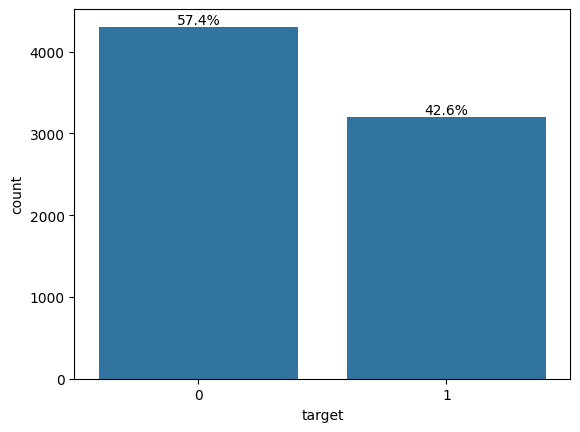

In [96]:
p = sns.countplot(data=tweet, x='target')
p.bar_label(p.containers[0], fmt=lambda x: f'{(x/len(tweet))*100:0.1f}%')

#### After removing duplicates from the tweet dataframe 'text' column, 57% are now 0 or NON disaster tweets and 42% ARE classified as disaster tweets

## Observing some of the data

In [97]:
# First, 3 samples of True disaster tweets
np.random.seed(10)
print(tweet[tweet['target']==1].sample(3)['text'].values)

['#TeamFollowBack Madhya Pradesh Train Derailment: Village Youth Saved Many Lives  #FollowBack'
 'Firefigthers Evacuate from Northampton Township House Fire http://t.co/hPplD1jHtZ'
 "@breakingnewslh @bree_mars watch cnn's the seventies terrorism episode. Iran has always hated the U.S. They want us obliterated."]


In [98]:
# Next, 3 samples of tweets that are NOT disaster tweets
print(tweet[tweet['target']==0].sample(3)['text'].values)

['My 2 fav worlds have collided! Thanks to @lennonparham @Jessica_StClair I found the @GilmoreGuysShow podcast!! #ihave44episodesofGG #nojoke'
 'Not because i want to cheat or anything. Just feels good to vent to my twitter without a txt being screamed at lol'
 "i still don't see the point of a frozen sequel like where's the wreck it ralph sequel"]


## Text Cleaning & Preprocessing

#### In natural language processing, text needs to be cleaned and preprocessed before being fed into a model. Removing punctuations, stop words (such as 'I', 'is', 'the', etc), setting text to lowercase, port stemming (leaving the root word be removing tense) and also tokenizing or using a countvectorizer helps the model process and analyze text easier.

#### Below, I created the clean_text() function to take in each text line, set it to lowercase, remove punctuation, remove English stopwords, stem the words, then join as string for the return value. 

In [88]:

stop_words = stopwords.words('english')
np.array(stop_words)
stemmer = PorterStemmer()

def clean_text(text):
   # text to lowercase
   lower = text.lower()
   # remove punctuation
   import string
   trans = str.maketrans('', '', string.punctuation)
   no_punc = lower.translate(trans)
   # remove stopwords
   tokens = word_tokenize(no_punc)
   no_stop = [word for word in tokens if word not in stop_words]
   # Stem words
   stemmed = [stemmer.stem(word) for word in no_stop]
   return ' '.join(stemmed)



In [99]:
tweet.head(10)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
5,#RockyFire Update => California Hwy. 20 closed...,1
6,#flood #disaster Heavy rain causes flash flood...,1
7,I'm on top of the hill and I can see a fire in...,1
8,There's an emergency evacuation happening now ...,1
9,I'm afraid that the tornado is coming to our a...,1


In [101]:
tweet['text'] = tweet['text'].apply(clean_text)

## Applying clean_text() function

#### We can see the difference from the original text above to the cleaned text below

In [102]:
tweet['text'][:10]

0            deed reason earthquak may allah forgiv us
1                 forest fire near la rong sask canada
2    resid ask shelter place notifi offic evacu she...
3    13000 peopl receiv wildfir evacu order california
4    got sent photo rubi alaska smoke wildfir pour ...
5    rockyfir updat california hwi 20 close direct ...
6    flood disast heavi rain caus flash flood stree...
7                            im top hill see fire wood
8         there emerg evacu happen build across street
9                          im afraid tornado come area
Name: text, dtype: object

## SKLearn's CountVectorizer

#### We can now apply CountVectorizer which transforms the text into a vector based on frequency of each word as it occurs in the text. 

In [103]:
count_vec = CountVectorizer()
count_vec.fit(tweet['text'])

CountVectorizer()

In [104]:
count_vec.vocabulary_

{'deed': 3790,
 'reason': 15271,
 'earthquak': 4384,
 'may': 12886,
 'allah': 1058,
 'forgiv': 5248,
 'us': 18270,
 'forest': 5241,
 'fire': 5089,
 'near': 13609,
 'la': 12120,
 'rong': 15688,
 'sask': 15943,
 'canada': 2558,
 'resid': 15459,
 'ask': 1434,
 'shelter': 16260,
 'place': 14634,
 'notifi': 13856,
 'offic': 13993,
 'evacu': 4737,
 'order': 14163,
 'expect': 4803,
 '13000': 138,
 'peopl': 14472,
 'receiv': 15287,
 'wildfir': 18802,
 'california': 2521,
 'got': 5726,
 'sent': 16142,
 'photo': 14556,
 'rubi': 15769,
 'alaska': 1012,
 'smoke': 16544,
 'pour': 14782,
 'school': 16010,
 'rockyfir': 15647,
 'updat': 18235,
 'hwi': 11063,
 '20': 253,
 'close': 3028,
 'direct': 4010,
 'due': 4313,
 'lake': 12140,
 'counti': 3366,
 'cafir': 2494,
 'flood': 5163,
 'disast': 4025,
 'heavi': 6121,
 'rain': 15160,
 'caus': 2692,
 'flash': 5132,
 'street': 16995,
 'manit': 12755,
 'colorado': 3142,
 'spring': 16796,
 'area': 1334,
 'im': 11193,
 'top': 17784,
 'hill': 6228,
 'see': 16091,

In [105]:
train_vec = count_vec.transform(tweet['text'])
test_vec = count_vec.transform(test['text'])

In [106]:
print(train_vec.shape)
print(test_vec.shape)

(7503, 19325)
(3263, 19325)


## Model Architecture

#### First, we will split the training data using sklearn's train_test_split into 80/20 training/test. For the model, I'll use sklearn's logistic regression since we are predicting a binary output (0 for NOT disaster tweet, 1 for disaster tweet)

In [107]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_vec, tweet['target'], test_size=0.2, random_state=42)

In [108]:
model = linear_model.LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [109]:
preds = model.predict(X_test)

## Model Evaluation

#### For the Kaggle competition, F1 scores are used to determine accuracy between predicted values and true values.

In [110]:
f1 = metrics.f1_score(y_test, preds)
print(f'F1 Score: {f1 * 100:.2f}%')

F1 Score: 73.45%


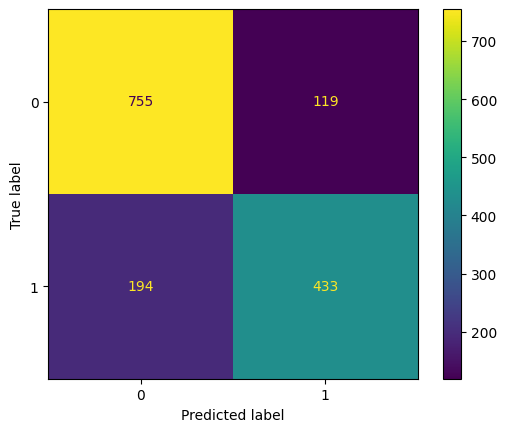

In [111]:
cm = metrics.confusion_matrix(y_test, preds)
cm_plot = metrics.ConfusionMatrixDisplay(cm, display_labels=[0, 1])
cm_plot.plot()

## Findings and Conclusion

#### After making the predictions of the X_test data and comparing to the y_test 'target' data, the F1 Score for the model was about 73%. Not bad but could probably get better with other text cleaning or perhaps a different model for classification. We can also see in the confusion matrix above, that the model predicted 755 True Positives and 433 True Negatives correctly. For the incorrect predictions, there were 194 False Negatives and 119 False Positives.

## Final Predictions and Submission CSV

In [112]:
test_preds = model.predict(test_vec)

In [113]:
submission = pd.read_csv(f'{path}/sample_submission.csv')
submission['target'] = test_preds
submission.to_csv('nlp_submission.csv', index=False)
submission.head(10)

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1
5,12,0
6,21,0
7,22,0
8,27,0
9,29,0
